In [1]:
import cobra
from cobra import Model, Reaction, Metabolite

In [2]:
import mewpy
from mewpy.simulation import SimulationMethod
from mewpy.optimization.evaluation import BPCY,WYIELD
from mewpy.problems import GOUProblem

In [3]:
cd "C:\Users\Asus\Desktop\Bioinformática\2º Semestre\Projeto de Bioinformática e Biologia de Sistemas"

C:\Users\Asus\Desktop\Bioinformática\2º Semestre\Projeto de Bioinformática e Biologia de Sistemas


In [4]:
M_1_2 = cobra.io.read_sbml_model('iJN746_metabolitos.xml')

In [5]:
print('Number of reactions: ',len(M_1_2.reactions))
print('Number of metabolites: ',len(M_1_2.metabolites))
print('Number of genes: ',len(M_1_2.genes))

Number of reactions:  1065
Number of metabolites:  915
Number of genes:  746


### Função objetivo e fluxo da biomassa no wild type

In [6]:
objective2 = M_1_2.problem.Objective(
    M_1_2.reactions.BIOMASS_KT_TEMP.flux_expression,
    direction = 'max')

In [7]:
M_1_2.objective = objective2

In [8]:
M_1_2.objective.expression

1.0*BIOMASS_KT_TEMP - 1.0*BIOMASS_KT_TEMP_reverse_d18f7

In [9]:
M_1_2.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
fe2_e,EX_fe2_e,0.0014,0,0.00%
glc__D_e,EX_glc__D_e,8.262,6,87.72%
nh4_e,EX_nh4_e,14.44,0,0.00%
o2_e,EX_o2_e,4.065,0,0.00%
pi_e,EX_pi_e,1.072,0,0.00%
so4_e,EX_so4_e,0.3263,0,0.00%
mhpglu_c,SK_5mthglu_c,0.2744,25,12.14%
dna5mtc_c,SK_dna5mtc_c,0.007,11,0.14%
Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,-2.919,1,28.15%


In [10]:
for x in M_1_2.reactions:
    print("%s : %s" % (x.id, x.reaction))

EX_gly_e : gly_e --> 
3OAR141 : 3ocmrs7eACP_c + h_c + nadph_c --> 3hcmrs7eACP_c + nadp_c
EX_glyald_e : glyald_e --> 
3OAR160 : 3opalmACP_c + h_c + nadph_c <=> 3hpalmACP_c + nadp_c
3OAR161 : 3ocpalm9eACP_c + h_c + nadph_c --> 3hcpalm9eACP_c + nadp_c
3OAR180 : 3ooctdACP_c + h_c + nadph_c <=> 3hoctaACP_c + nadp_c
3OAR181 : 3ocvac11eACP_c + h_c + nadph_c --> 3hcvac11eACP_c + nadp_c
ACS : ac_c + atp_c + coa_c <=> accoa_c + amp_c + ppi_c
ACt2rpp : ac_p + h_p --> ac_c + h_c
3OAR40 : actACP_c + h_c + nadph_c <=> 3haACP_c + nadp_c
EX_cit_e : cit_e --> 
EX_co2_e : co2_e <=> 
3OAR60 : 3ohexACP_c + h_c + nadph_c <=> 3hhexACP_c + nadp_c
3OAR80 : 3ooctACP_c + h_c + nadph_c <=> 3hoctACP_c + nadp_c
3OAS100 : h_c + malACP_c + ocACP_c --> 3odecACP_c + ACP_c + co2_c
3OAS120 : dcaACP_c + h_c + malACP_c --> 3oddecACP_c + ACP_c + co2_c
3OAS121 : cdec3eACP_c + h_c + malACP_c --> 3ocddec5eACP_c + ACP_c + co2_c
ACtex : ac_e <=> ac_p
3OAS140 : ddcaACP_c + h_c + malACP_c --> 3omrsACP_c + ACP_c + co2_c
ADA : adn_

### Função objetivo e fluxo do HAA

In [11]:
objective1 = M_1_2.problem.Objective(
    M_1_2.reactions.R_EX_HAA.flux_expression, 
    direction = 'max')

In [12]:
M_1_2.objective = objective1

In [13]:
M_1_2.objective.expression

1.0*R_EX_HAA - 1.0*R_EX_HAA_reverse_f8213

In [14]:
M_1_2.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
fe2_e,EX_fe2_e,0.001,0,0.00%
glc__D_e,EX_glc__D_e,20,6,96.03%
nh4_e,EX_nh4_e,35.28,0,0.00%
o2_e,EX_o2_e,1.969,0,0.00%
pi_e,EX_pi_e,11.47,0,0.00%
so4_e,EX_so4_e,3.8,0,0.00%
mhpglu_c,SK_5mthglu_c,0.196,25,3.92%
dna5mtc_c,SK_dna5mtc_c,0.005,11,0.04%
Metabolite,Reaction,Flux,C-Number,C-Flux
h2o_e,EX_h2o_e,-91.05,0,0.00%


### Simulações

In [15]:
from mewpy.simulation import get_simulator
simul = get_simulator(M_1_2)

In [16]:
constraints = {'BIOMASS_KT_TEMP': (0.14, 1000)}

# run a pFBA simulation accounting with the new constraint
result = simul.simulate(method='pFBA',constraints=constraints)

result.fluxes['BIOMASS_KT_TEMP']

0.14

In [17]:
result

objective: 1633.2472713675502
Status: OPTIMAL
Constraints: OrderedDict([('BIOMASS_KT_TEMP', (0.14, 1000))])
Method:pFBA

### Simulações BCPY para maximizar a produção de HAA

#### Problema RKO (Reaction Constraint Problems)

In [19]:
# Define the target
PRODUCT_ID = 'R_EX_HAA'
BIOMASS_ID = 'BIOMASS_KT_TEMP'

# environmental conditions
envcond = {'BIOMASS_KT_TEMP': (0.14, 1000)}

# Optimization objectives

evaluator_1 = BPCY(BIOMASS_ID, PRODUCT_ID, method='pFBA')
evaluator_2 = WYIELD(BIOMASS_ID, PRODUCT_ID)

# build a new reaction deletion problem instance
from mewpy.problems import RKOProblem

problem = RKOProblem(M_1_2, 
               fevaluation=[evaluator_1, evaluator_2], 
               envcond=envcond)


Building modification target list.
Computing essential reactions:


  0%|          | 0/1065 [00:00<?, ?it/s]C:\Users\Asus\anaconda3\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
100%|██████████| 1065/1065 [00:28<00:00, 37.38it/s]


Running NSGAII


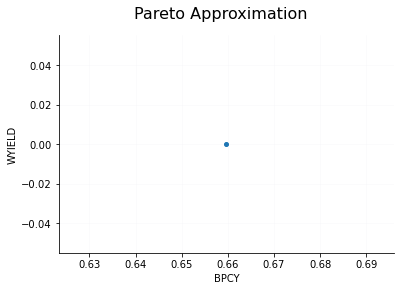

In [20]:
# run the optimization
from mewpy.optimization import EA

ea = EA(problem, max_generations= 50, visualizer=True)
final_pop = ea.run()

In [21]:
# Save the solutions to a csv file
from mewpy.util.io import population_to_csv
population_to_csv(problem,final_pop,'resultsRKOpfba50_HAA.csv')

In [22]:
final_pop[0:50]

[[0.6597095633142843, 0.0];{'PSD161': 0, 'PSD181': 0}]

#### Problema ROU

In [23]:
from mewpy.problems import ROUProblem

problem1 = ROUProblem(M_1_2, 
               fevaluation=[evaluator_1, evaluator_2], 
               envcond=envcond)

Building modification target list.
Running NSGAII


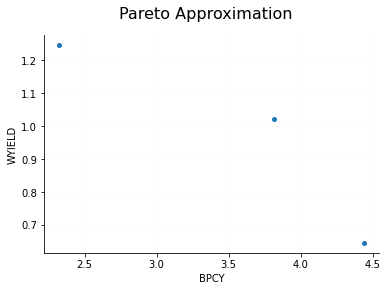

In [24]:
ea1 = EA(problem1, max_generations= 50, visualizer=True)
final_pop1 = ea1.run()

In [25]:
from mewpy.util.io import population_to_csv
population_to_csv(problem1,final_pop1,'resultsROUpfba50_HAA.csv')

In [27]:
final_pop1[0:200]

[[4.438188546922377, 0.6449570225498348];{'NDPK2': 16},
 [3.815882452056143, 2.5130512112906516];{'NADK': 8, 'EX_h2o_e': 2},
 [3.8131176520981924, 2.51509027622442];{'EX_h2o_e': 2, 'NADK': 8, 'PGMT': 32},
 [3.813117652143842, 2.51509027622442];{'NADK': 8, 'ACOTA': 2, 'CITtex': 0.25, 'NAtex': 0, 'PGMT': 32, 'PSD120': 8, 'EX_h2o_e': 2},
 [3.813117652143842, 2.51509027622442];{'SPMS': 0.0625, 'ACOTA': 2, 'CITtex': 0.25, 'NAtex': 0, 'PGMT': 32, 'PSD120': 8, 'EX_h2o_e': 2},
 [3.813117652143842, 2.51509027622442];{'SPMS': 0.0625, 'NADK': 8, 'CITtex': 0.25, 'NAtex': 0, 'PGMT': 32, 'PSD120': 8, 'EX_h2o_e': 2},
 [3.813117652143842, 2.51509027622442];{'SPMS': 0.0625, 'NADK': 8, 'ACOTA': 2, 'NAtex': 0, 'PGMT': 32, 'PSD120': 8, 'EX_h2o_e': 2},
 [3.813117652143842, 2.51509027622442];{'SPMS': 0.0625, 'NADK': 8, 'ACOTA': 2, 'CITtex': 0.25, 'PGMT': 32, 'PSD120': 8, 'EX_h2o_e': 2},
 [3.813117652143842, 2.51509027622442];{'SPMS': 0.0625, 'NADK': 8, 'ACOTA': 2, 'CITtex': 0.25, 'NAtex': 0, 'PGMT': 32, 'EX

#### Problema GKO (Gene Constraint Problems)

In [28]:
# build a new problem instance
from mewpy.problems import GKOProblem
problem2 = GKOProblem(M_1_2, fevaluation=[
                         evaluator_1, evaluator_2], envcond=envcond)

Building modification target list.
Computing essential genes:


  0%|          | 2/746 [00:00<05:13,  2.37it/s]C:\Users\Asus\anaconda3\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
100%|██████████| 746/746 [05:47<00:00,  2.15it/s]


Running NSGAII


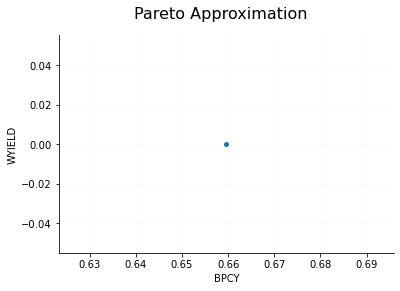

In [29]:
ea2 = EA(problem2, max_generations= 50, visualizer=True)
final_pop2 = ea2.run()

In [30]:
final_pop2[0:50]

[[0.6596231633142853, 0.0];{}]

In [31]:
from mewpy.util.io import population_to_csv

population_to_csv(problem2,final_pop2,'resultsGKOpfba50_HAA.csv')

#### Problema GOU

In [11]:
# build a new problem instance - gene over- or under expression optimization
from mewpy.problems import GOUProblem
problem3 = GOUProblem(M_1_2, fevaluation=[
                         evaluator_1, evaluator_2], envcond=envcond)

Running NSGAII


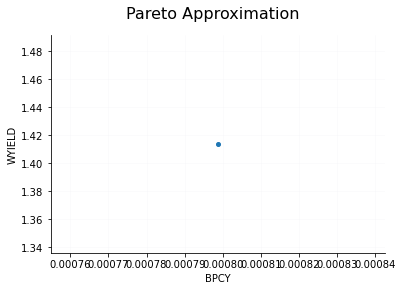

In [ ]:
from mewpy.optimization import EA
ea3 = EA(problem3, max_generations = 50, mp = True, visualizer=True)
final_pop3 = ea3.run()

In [ ]:
from mewpy.util.io import population_to_csv

population_to_csv(problem3,final_pop3,'resultsGOUpfba50_HAA.csv')

In [15]:
final_pop3[0:280]

[[0.02472821409584534, 1.4181891676301646];{'PP_2998': 32},
 [0.003182505477536637, 1.4183219235992828];{'PP_1179': 0.125, 'PP_2998': 32},
 [0.012580256946787154, 1.4182649386993753];{'PP_2998': 32, 'PP_0967': 0.5},
 [0.006340050127835853, 1.418302928632654];{'PP_5132': 0.25, 'PP_2998': 32},
 [1.1643882090631188, 0.0];{'PP_4998': 4},
 [0.02469616350626921, 1.418189370853933];{'PP_3746': 0.125, 'PP_2998': 32}]